## Notebook 4: 

This is an IPython notebook. Most of the code is composed of bash scripts, indicated by %%bash at the top of the cell, otherwise it is IPython code. This notebook includes code to download, assemble and analyze a published RADseq data set.

In [34]:
### Notebook 4
### Data set 4 (Orestias)
### Authors: Takahashi & Moreno (2015)
### Data Location: DDBJ DRA DRA003595

## Download the sequence data
Sequence data for this study are archived on the NCBI sequence read archive (SRA). Below I read in SraRunTable.txt for this project which contains all of the information we need to download the data. 

+ Project DRA: DRA003595
+ Study: DRP002750
+ Experiments: DRX033006 -- DRX033069
+ Samples: DRS020928 -- DRS020991
+ SRA link: http://trace.ddbj.nig.ac.jp/DRASearch/submission?acc=DRA003595
+ Publication address: __doi:10.1016/j.ympev.2015.08.012__

In [4]:
%%bash
## make a new directory for this analysis
mkdir -p empirical_4/fastq/

In [16]:
import os

def wget_download_ddbj(SRR, outdir):
    """ Python function to get sra data from ncbi and write to
    outdir with a new name using bash call wget """
    
    ## create a call string 
    call = "wget -q -r -nH --cut-dirs=9 -P "+outdir+" "+\
           "ftp://ftp.ddbj.nig.ac.jp/ddbj_database/dra/sra/ByExp/"+\
           "sra/DRX/DRX033/DRX033{:03d}".format(SRR)
    
    ## run wget call 
    ! $call

Here we pass the SRR number and the sample name to the `wget_download` function so that the files are saved. In this case we do not have the sample names, just their SRR IDs. 

In [17]:
for ID in range(6,70):
    wget_download_ddbj(ID, "empirical_4/fastq/")

In [18]:
%%bash
## convert sra files to fastq using fastq-dump tool
## output as gzipped into the fastq directory
fastq-dump --gzip -O empirical_4/fastq/  empirical_4/fastq/*.sra

## remove .sra files
rm empirical_4/fastq/*.sra

Read 3850280 spots for empirical_4/fastq/DRR036765.sra
Written 3850280 spots for empirical_4/fastq/DRR036765.sra
Read 5135835 spots for empirical_4/fastq/DRR036766.sra
Written 5135835 spots for empirical_4/fastq/DRR036766.sra
Read 3812927 spots for empirical_4/fastq/DRR036767.sra
Written 3812927 spots for empirical_4/fastq/DRR036767.sra
Read 4279789 spots for empirical_4/fastq/DRR036768.sra
Written 4279789 spots for empirical_4/fastq/DRR036768.sra
Read 4238415 spots for empirical_4/fastq/DRR036769.sra
Written 4238415 spots for empirical_4/fastq/DRR036769.sra
Read 4897736 spots for empirical_4/fastq/DRR036770.sra
Written 4897736 spots for empirical_4/fastq/DRR036770.sra
Read 4110217 spots for empirical_4/fastq/DRR036771.sra
Written 4110217 spots for empirical_4/fastq/DRR036771.sra
Read 4381798 spots for empirical_4/fastq/DRR036772.sra
Written 4381798 spots for empirical_4/fastq/DRR036772.sra
Read 3692455 spots for empirical_4/fastq/DRR036773.sra
Written 3692455 spots for empirical_4/fas

## Make a params file

In [19]:
%%bash
pyrad --version

pyRAD 3.0.63


In [20]:
%%bash
## delete existing params file if it exits
rm params.txt

## create a new default params file
pyrad -n 

	new params.txt file created


In [10]:
%%bash
## substitute new parameters into file
sed -i '/## 1. /c\empirical_4/           ## 1. working directory ' params.txt
sed -i '/## 6. /c\TGCAGG                 ## 6. cutters ' params.txt
sed -i '/## 7. /c\30                     ## 7. N processors      ' params.txt
sed -i '/## 9. /c\6                      ## 9. NQual             ' params.txt
sed -i '/## 10./c\.85                    ## 10. clust threshold  ' params.txt
sed -i '/## 12./c\4                      ## 12. MinCov           ' params.txt
sed -i '/## 13./c\10                     ## 13. maxSH            ' params.txt
sed -i '/## 14./c\empirical_4_m4         ## 14. output name      ' params.txt
sed -i '/## 18./c\empirical_4/fastq/*.gz ## 18. data location    ' params.txt
sed -i '/## 29./c\2,2                    ## 29. trim overhang    ' params.txt
sed -i '/## 30./c\p,n,s                  ## 30. output formats   ' params.txt

In [11]:
cat params.txt

==** parameter inputs for pyRAD version 3.0.63  **======================== affected step ==
empirical_4/           ## 1. working directory 
./*.fastq.gz              ## 2. Loc. of non-demultiplexed files (if not line 18)  (s1)
./*.barcodes              ## 3. Loc. of barcode file (if not line 18)             (s1)
vsearch                   ## 4. command (or path) to call vsearch (or usearch)    (s3,s6)
muscle                    ## 5. command (or path) to call muscle                  (s3,s7)
TGCAGG                 ## 6. cutters 
30                     ## 7. N processors      
6                         ## 8. Mindepth: min coverage for a cluster              (s4,s5)
6                      ## 9. NQual             
.85                    ## 10. clust threshold  
rad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)
4                      ## 12. MinCov           
10                     ## 13. maxSH            
empirical_4_m4         ## 14. output name     

## Assemble in _pyrad_

In [ ]:
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [16]:
%%bash
sed -i '/## 12./c\2                      ## 12. MinCov           ' params.txt
sed -i '/## 14./c\empirical_4_m2         ## 14. output name      ' params.txt

In [17]:
%%bash
pyrad -p params.txt -s 7 >> log.txt 2>&1

## Results
We are interested in the relationship between the amount of input (raw) data between any two samples, the average coverage they recover when clustered together, and the phylogenetic distances separating samples.  

#### Raw data amounts
The average number of raw reads per sample is 1.36M.

In [15]:
## import data frame 
import pandas as pd

## read in the data
s4dat = pd.read_table("empirical_4/stats/s2.rawedit.txt", header=0, nrows=65)

## print summary stats
print s4dat["passed.total"].describe()

## find which sample has the most raw data
maxraw = s4dat["passed.total"].max()
print "\nmost raw data in sample:"
print s4dat['sample '][s4dat['passed.total']==maxraw]

count         64.000000
mean     3959338.812500
std       811579.026685
min       731712.000000
25%      3635737.000000
50%      4054918.000000
75%      4540098.750000
max      5074496.000000
Name: passed.total, dtype: float64

most raw data in sample:
10    DRR036775
Name: sample , dtype: object


### Look at distributions of coverage
pyrad v.3.0.63 outputs depth information for each sample which I read in here and plot. First let's ask which sample has the highest depth of coverage. 

In [18]:
## read in the s3 results
s4dat = pd.read_table("empirical_4/stats/s3.clusters.txt", header=0, nrows=65)

## print summary stats
print "summary of means\n=================="
print s4dat['dpt.me'].describe()

## print summary stats
print "\nsummary of std\n=================="
print s4dat['dpt.sd'].describe()

## print summary stats
print "\nsummary of proportion lowdepth\n=================="
print pd.Series(1-s4dat['d>5.tot']/s4dat["total"]).describe()

## find which sample has the greatest depth of retained loci
max_hiprop = (s4dat["d>5.tot"]/s4dat["total"]).max()
print "\nhighest coverage in sample:"
print s4dat['taxa'][s4dat['d>5.tot']/s4dat["total"]==max_hiprop]

summary of means
count     64.000000
mean     106.000750
std       17.392284
min       40.235000
25%       98.422750
50%      107.650000
75%      118.500750
max      131.455000
Name: dpt.me, dtype: float64

summary of std
count     64.000000
mean     289.564375
std      140.245059
min       95.184000
25%      205.293000
50%      235.668500
75%      325.144000
max      757.646000
Name: dpt.sd, dtype: float64

summary of proportion lowdepth
count    64.000000
mean      0.053360
std       0.010158
min       0.038625
25%       0.046790
50%       0.051447
75%       0.058441
max       0.104888
dtype: float64

highest coverage in sample:
10    DRR036775
Name: taxa, dtype: object


#### Plot the coverage for the sample with highest mean coverage
Green shows the loci that were discarded and orange the loci that were retained. The majority of data were discarded for being too low of coverage. 

In [9]:
import toyplot
import toyplot.svg
import numpy as np

## read in the depth information for this sample
with open("empirical_4/clust.85/DRR036775.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
## make a barplot in Toyplot
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.axes(xlabel="Depth of coverage (N reads)", 
                   ylabel="N loci", 
                   label="dataset4/sample=DRR036775")

## select the loci with depth > 5 (kept)
keeps = depths[depths>5]

## plot kept and discarded loci
edat = np.histogram(depths, range(30)) # density=True)
kdat = np.histogram(keeps, range(30)) #, density=True)
axes.bars(edat)
axes.bars(kdat)

#toyplot.svg.render(canvas, "empirical_4_depthplot.svg")

### Print final stats table

In [30]:
cat empirical_4/stats/empirical_4_m4.stats




46277       ## loci with > minsp containing data
42877       ## loci with > minsp containing data & paralogs removed
42877       ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
DRR036765	27950
DRR036766	30223
DRR036767	29273
DRR036768	28909
DRR036769	28879
DRR036770	29524
DRR036771	28375
DRR036772	28756
DRR036773	27906
DRR036774	28927
DRR036775	31633
DRR036776	27658
DRR036777	30722
DRR036778	28349
DRR036779	27420
DRR036780	29359
DRR036781	28123
DRR036782	29928
DRR036783	29606
DRR036784	28864
DRR036785	25495
DRR036786	28829
DRR036787	29177
DRR036788	28432
DRR036789	28598
DRR036790	13855
DRR036791	28826
DRR036792	27106
DRR036793	30117
DRR036794	30466
DRR036795	29279
DRR036796	28378
DRR036797	29160
DRR036798	28070
DRR036799	29059
DRR036800	29404
DRR036801	28522
DRR036802	27407
DRR036803	22502
DRR036804	29971
DRR036805	26894
DRR036806	28787
DRR036807	30322
DRR036808	29587
DRR036809	28472


In [19]:
%%bash
head -n 20 empirical_4/stats/empirical_4_m2.stats




48546       ## loci with > minsp containing data
45146       ## loci with > minsp containing data & paralogs removed
45146       ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
DRR036765	28070
DRR036766	30376
DRR036767	29411
DRR036768	29051
DRR036769	29022
DRR036770	29587
DRR036771	28435
DRR036772	28812
DRR036773	27965
DRR036774	28996
DRR036775	31778
DRR036776	27701


## Infer ML phylogeny in _raxml_ as an unrooted tree

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_4/ \
                      -n empirical_4_m4 -s empirical_4/outfiles/empirical_4_m4.phy
                      

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_4/ \
                      -n empirical_4_m2 -s empirical_4/outfiles/empirical_4_m2.phy
                      

In [2]:
%%bash
head -n 40 empirical_4/RAxML_info.empirical_4



This is RAxML version 8.0.16 released by Alexandros Stamatakis on March 21 2014.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 339249 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 33.82%

RAxML rapid bootstrapping and subsequent ML search

Using 1 distinct models/data partitions with joint branch length optimization



Executing 100 rapid bootstrap inferences and thereafter a thorough ML search 

All free model parameters will be estimated by RAxML
GAMMA model of rate heteorgeneity, ML estimate of alpha-parameter

GAMMA Model parameters will be estimated up to an accuracy of 0.1000000000 Log Likelihood units

Partition: 0
Alignment Patterns: 339249
Name: No Name Provided
DataType: DNA
Substitution Matrix: GTR


### Plot the tree in R using `ape`
The backbone of the ingroup taxa has very low support across the radiation. The same result was found in the original paper (see Fig. 4 and Supplemental Fig S1 of Takahashi et al). Below we plot the full tree and a zoomed in tree of just the ingroup taxa. 

In [21]:
%load_ext rpy2.ipython

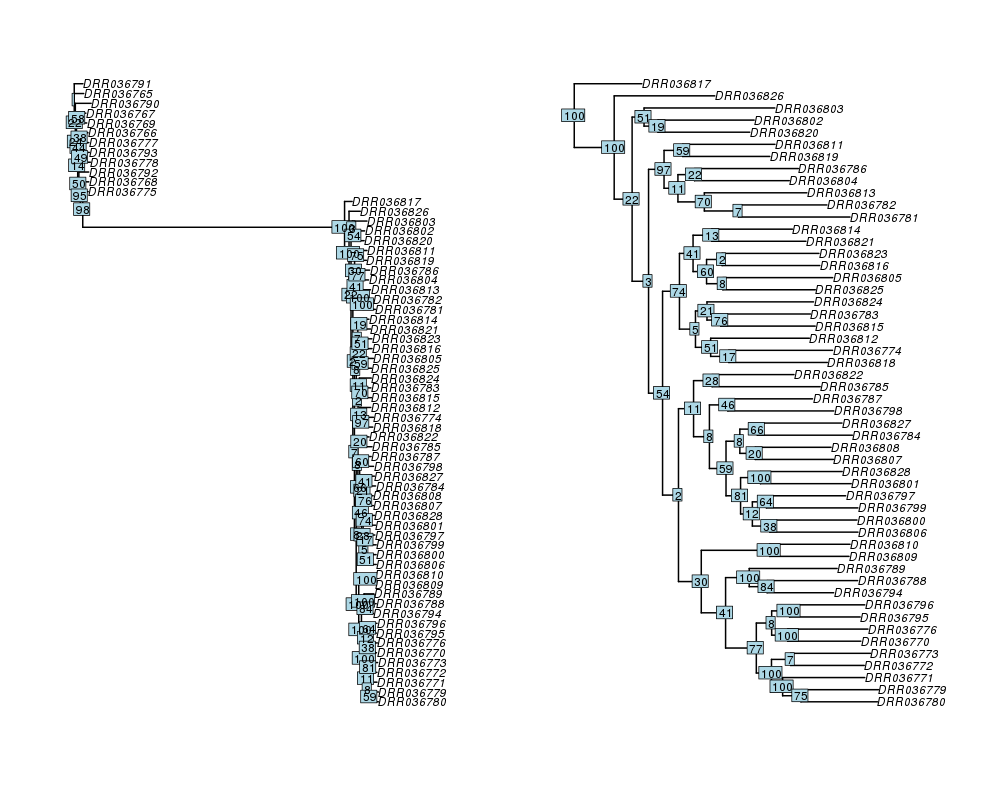

In [27]:
%%R -w 1000 -h 800
library(ape)
tre <- read.tree("empirical_4/RAxML_bipartitions.empirical_4")
ltre <- ladderize(tre)
outgroups = c("DRR036791", "DRR036765", "DRR036790", "DRR036767", "DRR036769",
              "DRR036766", "DRR036777", "DRR036793", "DRR036778", "DRR036778", 
              "DRR036792", "DRR036768", "DRR036775")
rtre <- root(ltre, outgroups)
ingrouptre <- drop.tip(ltre, outgroups)    
par(mfrow=c(1,2))

plot(ltre, edge.width=2)
nodelabels(ltre$node.label, cex=1)
plot(ingrouptre, edge.width=2)
nodelabels(ingrouptre$node.label, cex=1)

In [28]:
%%R
mean(cophenetic.phylo(ltre))

[1] 0.009676341


### An ultrametric tree for plotting 

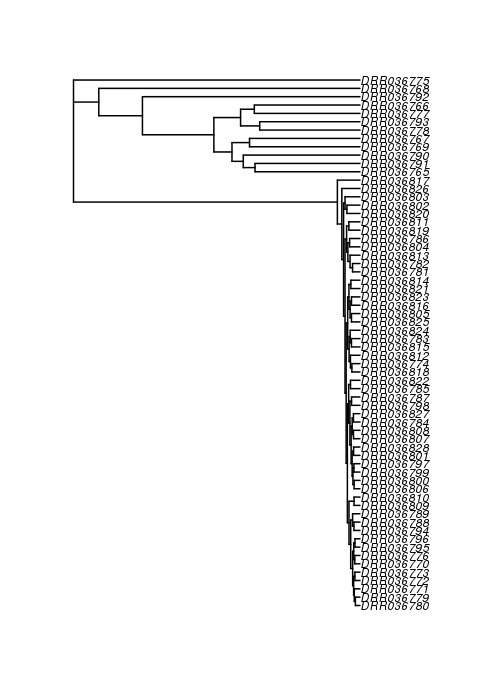

In [33]:
%%R -h 700
utre <- ladderize(chronopl(rtre, 0.5, resolve.root=TRUE))
plot(utre, edge.width=2)